In [1]:

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats.mstats import winsorize
import xgboost as xgb
from xgboost import XGBRegressor
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Configuración para la visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:

# Carga de los datos
data_path = '/Users/fernandopradagorge/Documents/Universidad/Master Data Science and AI/Nuclio Projects/Entregables/Entregable_3_Kaggle_31MAR24/ML_Time_Series/ts_kaggle_train.csv'  # Asegúrate de ajustar la ruta al archivo según tu entorno

try:
    df = pd.read_csv(data_path)
    # Visualización de las primeras filas del conjunto de datos
    print(df.head())
except FileNotFoundError:
    print(f"No se pudo encontrar el archivo en la ruta especificada: {data_path}")


   Unnamed: 0        date unique_id  city_id  shop_id  item_category_id  \
0           0  2013-01-31  12_11365       16       12                 9   
1           1  2013-01-31  12_11369       16       12                 9   
2           2  2013-01-31  12_11370       16       12                 9   
3           3  2013-01-31  12_11373       16       12                 9   
4           4  2013-01-31  12_12231       16       12                49   

   item_id  monthly_average_price  monthly_sales  
0    11365            1511.512626           30.0  
1    11369             572.715278           30.0  
2    11370             699.776786           30.0  
3    11373             548.900000            6.0  
4    12231             350.000000            3.0  


In [3]:

# Información general, estadísticas descriptivas y valores nulos del DataFrame
info_str = df.info()
desc = df.describe()
null_sum = df.isnull().sum()

print("Información General del DataFrame:")
print(info_str)
print("\nEstadísticas Descriptivas:")
print(desc)
print("\nValores Nulos por Columna:")
print(null_sum)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14484 non-null  int64  
 1   date                   14484 non-null  object 
 2   unique_id              14484 non-null  object 
 3   city_id                14484 non-null  int64  
 4   shop_id                14484 non-null  int64  
 5   item_category_id       14484 non-null  int64  
 6   item_id                14484 non-null  int64  
 7   monthly_average_price  13262 non-null  float64
 8   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1018.5+ KB
Información General del DataFrame:
None

Estadísticas Descriptivas:
         Unnamed: 0       city_id       shop_id  item_category_id  \
count  14484.000000  14484.000000  14484.000000      14484.000000   
mean    7241.500000     10.833333     31.967136  

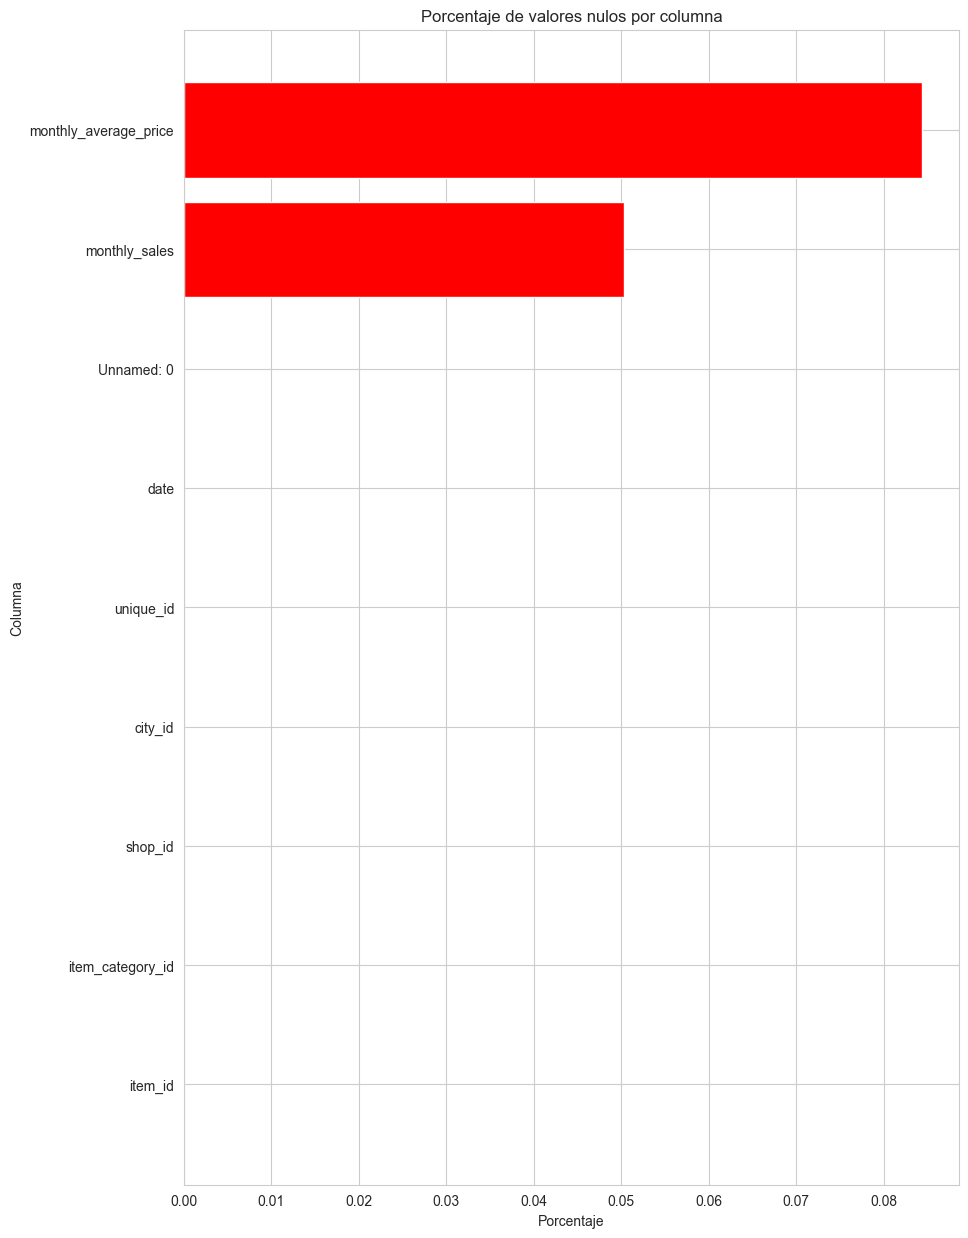

In [4]:

# Visualización del porcentaje de valores nulos por columna
df_null_values = df.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(10,15))
plt.barh(y=df_null_values.index, width=df_null_values, color='red')
plt.gca().invert_yaxis()  # Invertir el eje Y para orden correcto

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje')
plt.ylabel('Columna')
plt.show()


/var/folders/hn/58jsz1wd6jn8ypqlsj_ym3sc0000gn/T/ipykernel_27563/2367037206.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cardinality.values, y=cardinality.index, palette='coolwarm')


Text(0, 0.5, 'Columnas')

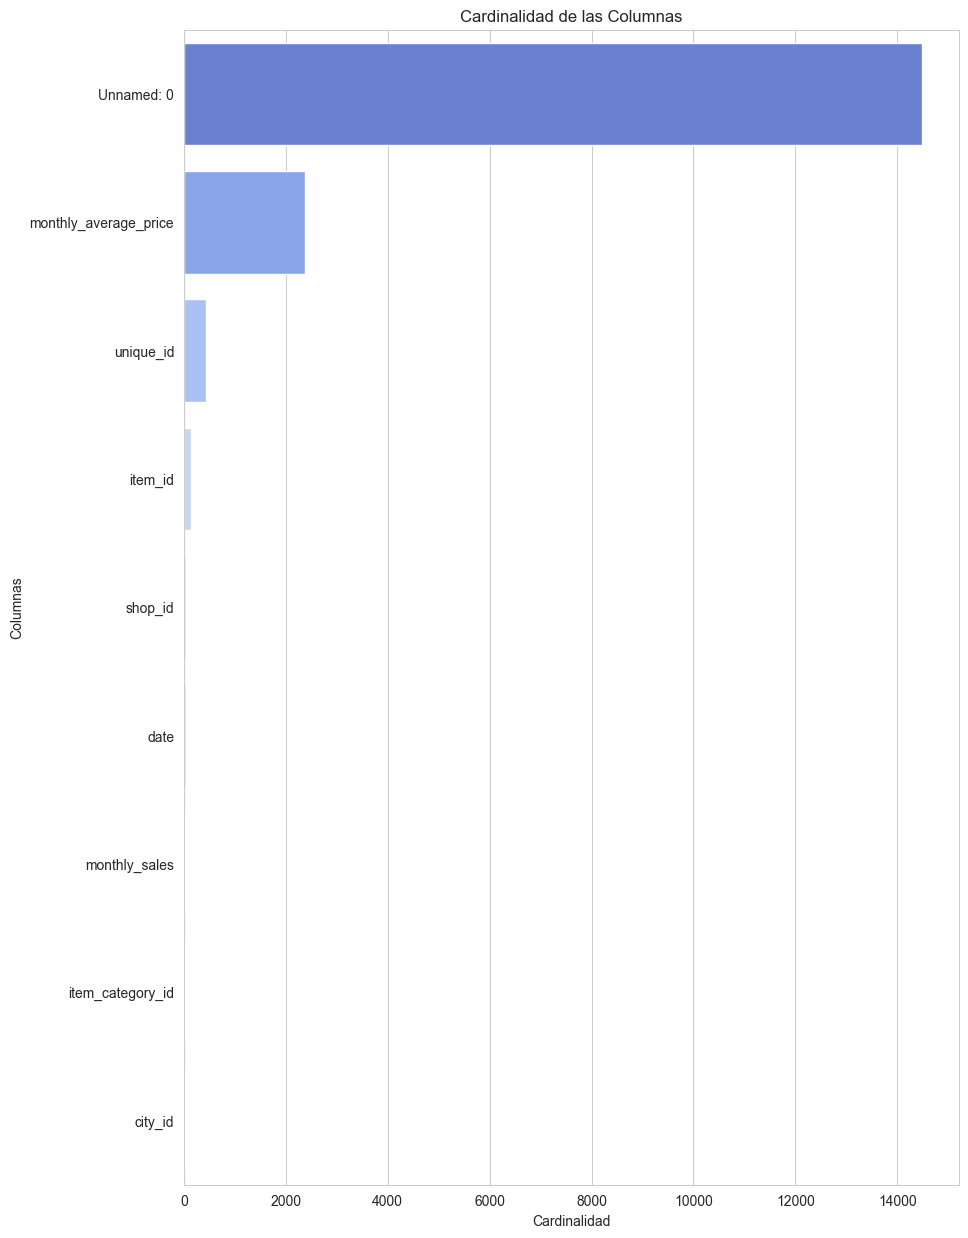

In [5]:

# Visualización de la cardinalidad de las columnas
cardinality = df.nunique().sort_values(ascending=False)
plt.figure(figsize=(10, 15))
sns.barplot(x=cardinality.values, y=cardinality.index, palette='coolwarm')
plt.title('Cardinalidad de las Columnas')
plt.xlabel('Cardinalidad')
plt.ylabel('Columnas')


In [6]:

# Imputación de valores nulos y definición de tareas en una Pipeline
num_features = df.select_dtypes(include=['int64', 'float64']).columns
cat_features = df.select_dtypes(include=['object']).columns

# Pipeline para características numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para características categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinación de pipelines en un solo preprocesador
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [7]:

# Preprocesamiento adicional: Extracción de características de fecha y eliminación de columnas innecesarias
def preprocess_dataframe(df):
    df_processed = df.copy()
    
    # Extracción de características de fecha
    if 'date' in df_processed.columns:
        df_processed['year'] = pd.to_datetime(df_processed['date']).dt.year
        df_processed['month'] = pd.to_datetime(df_processed['date']).dt.month
        df_processed['day'] = pd.to_datetime(df_processed['date']).dt.day
        df_processed.drop(['date'], axis=1, inplace=True)
    
    # Eliminación de columnas innecesarias
    if 'unique_id' in df_processed.columns:
        df_processed.drop(['unique_id'], axis=1, inplace=True)
    
    return df_processed

# Aplicar preprocesamiento al DataFrame original
df_preprocessed = preprocess_dataframe(df)


In [8]:

# Tratamiento de outliers en la columna 'monthly_sales'
def handle_outliers(df):
    df_outlier_handled = df.copy()
    
    # Asegurar que todos los valores son positivos
    df_outlier_handled['monthly_sales'] += abs(df_outlier_handled['monthly_sales'].min()) + 1
    
    # Aplicar transformación logarítmica
    df_outlier_handled['monthly_sales_log'] = np.log(df_outlier_handled['monthly_sales'])
    
    # Winsorización para limitar valores extremos
    lower_limit, upper_limit = 0.01, 0.99  # Percentiles para winsorización
    df_outlier_handled['monthly_sales_log_winsorized'] = winsorize(
        df_outlier_handled['monthly_sales_log'], limits=(lower_limit, upper_limit))
    
    # Transformación inversa para volver a la escala original
    df_outlier_handled['monthly_sales_winsorized_retransformed'] = np.exp(
        df_outlier_handled['monthly_sales_log_winsorized'])
    
    # Ajustar la transformación para la positividad inicial
    df_outlier_handled['monthly_sales_final'] = df_outlier_handled['monthly_sales_winsorized_retransformed'] - (
        abs(df_outlier_handled['monthly_sales'].min()) + 1)
    
    return df_outlier_handled

# Aplicar el tratamiento de outliers al DataFrame preprocesado
df_preprocessed = handle_outliers(df_preprocessed)


In [9]:

# Definición de características (X) y variable objetivo (y)
X = df_preprocessed.drop('monthly_sales_final', axis=1)
y = df_preprocessed['monthly_sales_final']

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:

# Verificación y manejo de valores NaN en y_train
nan_count = y_train.isna().sum()
print(f"Valores NaN en y_train: {nan_count}")

# Imputación de valores NaN con la mediana, si los hay
if nan_count > 0:
    y_train = y_train.fillna(y_train.median())

# Verificación y manejo de valores infinitos en y_train
inf_count = np.isinf(y_train).sum()
print(f"Valores infinitos en y_train: {inf_count}")

# Reemplazo de valores infinitos con NaN y posterior imputación con la mediana
if inf_count > 0:
    y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_train.fillna(y_train.median(), inplace=True)


Valores NaN en y_train: 0
Valores infinitos en y_train: 0


In [11]:
print(y_train.describe())

count    11587.0
mean        -1.0
std          0.0
min         -1.0
25%         -1.0
50%         -1.0
75%         -1.0
max         -1.0
Name: monthly_sales_final, dtype: float64


In [12]:

# Aplicación de una transformación logarítmica a y_train para normalizar la distribución
y_train = np.log1p(y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:

# Verificación y manejo final de valores NaN en X_train antes del entrenamiento del modelo
nan_count_X_train = X_train.isna().sum().sum()
print(f"Valores NaN totales en X_train antes de la imputación: {nan_count_X_train}")

# Imputación de valores NaN con la mediana, si los hay
if nan_count_X_train > 0:
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

nan_count_X_train_after = X_train.isna().sum().sum()
print(f"Valores NaN totales en X_train después de la imputación: {nan_count_X_train_after}")


Valores NaN totales en X_train antes de la imputación: 2163
Valores NaN totales en X_train después de la imputación: 0


In [14]:

# Configuración para la Optimización de Hiperparámetros
# Definir el espacio de búsqueda de los hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requerido para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requerido en un nodo hoja
    'max_features': ['auto', 'sqrt']  # Número de características a considerar al buscar la mejor división
}

# Inicializar GridSearchCV
# Asegúrate de ajustar 'estimator' al modelo específico que estás utilizando
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Entrenamiento utilizando GridSearchCV (descomenta la línea de abajo para ejecutar)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la mejor puntuación (descomenta las líneas de abajo para mostrar resultados)
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor puntuación (MSE): {grid_search.best_score_}")

# El mejor modelo se puede encontrar con: 
grid_search.best_estimator_


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None,

ValueError: 
All the 1080 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
265 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
275 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1208, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1218, in _check_y
    y = check_array(
        ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1003, in check_array
    _assert_all_finite(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input y contains infinity or a value too large for dtype('float64').


In [ ]:

# Configuración para la Búsqueda de un Modelo Más Simple
# Definir un espacio de búsqueda de hiperparámetros más limitado
param_grid_simple = {
    'n_estimators': [100]  # Ejemplo de hiperparámetro simplificado
}

# Inicializar GridSearchCV para el modelo simplificado
# Asegúrate de ajustar 'estimator' al modelo específico que estás utilizando
grid_search_simple = GridSearchCV(estimator=YOUR_MODEL_HERE, param_grid=param_grid_simple, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Entrenamiento utilizando GridSearchCV para el modelo simplificado (descomenta la línea de abajo para ejecutar)
# grid_search_simple.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la mejor puntuación para el modelo simplificado (descomenta las líneas de abajo para mostrar resultados)
# print(f"Mejores hiperparámetros (simplificado): {grid_search_simple.best_params_}")
# print(f"Mejor puntuación (MSE) (simplificado): {grid_search_simple.best_score_}")

# El mejor modelo simplificado se puede encontrar con: grid_search_simple.best_estimator_
